In [1]:
!wget https://storage.googleapis.com/learning-datasets/horse-or-human.zip
!mkdir horse-or-human
!unzip horse-or-human -d horse-or-human

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, utils

In [ ]:
model = keras.models.Sequential([
    keras.Input((300, 300, 3)),
    layers.Rescaling(1/255),

    layers.Conv2D(16, (3, 3), activation=tf.nn.relu),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation=tf.nn.relu),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation=tf.nn.relu),
    layers.Dropout(.2),
    layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.RMSprop(),
    metrics=['acc'],
)

In [ ]:
train_ds = utils.image_dataset_from_directory(
    'horse-or-human',
    label_mode='binary',
    image_size=(300, 300),
)
class_names = train_ds.class_names
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
model.fit(train_ds, epochs=5)

The model might misclassify images that are too different from its training data.

In [ ]:
imgs = tuple(
    utils.load_img(name, target_size=(300, 300))
    for name in ('horse.png', 'women.png')
)
predictions = model.predict(np.vstack(tuple(
    np.expand_dims(utils.img_to_array(img), axis=0)
    for img in imgs
)))
_, axs = plt.subplots(1, len(imgs))
for i, (img, x) in enumerate(zip(imgs, predictions)):
    axs[i].imshow(img)
    x = x[0]
    axs[i].set_title(f'{abs(1 - round(x) - x) * 100:.2}'
                     f'% {class_names[round(x)]}')

In [6]:
offset = 1
num_l = 10
features_model = keras.Model(
    inputs=model.inputs,
    outputs=[layer.output for layer in model.layers[offset:num_l+offset]]
)
layer_names = [layer.name for layer in model.layers[offset:num_l+offset]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


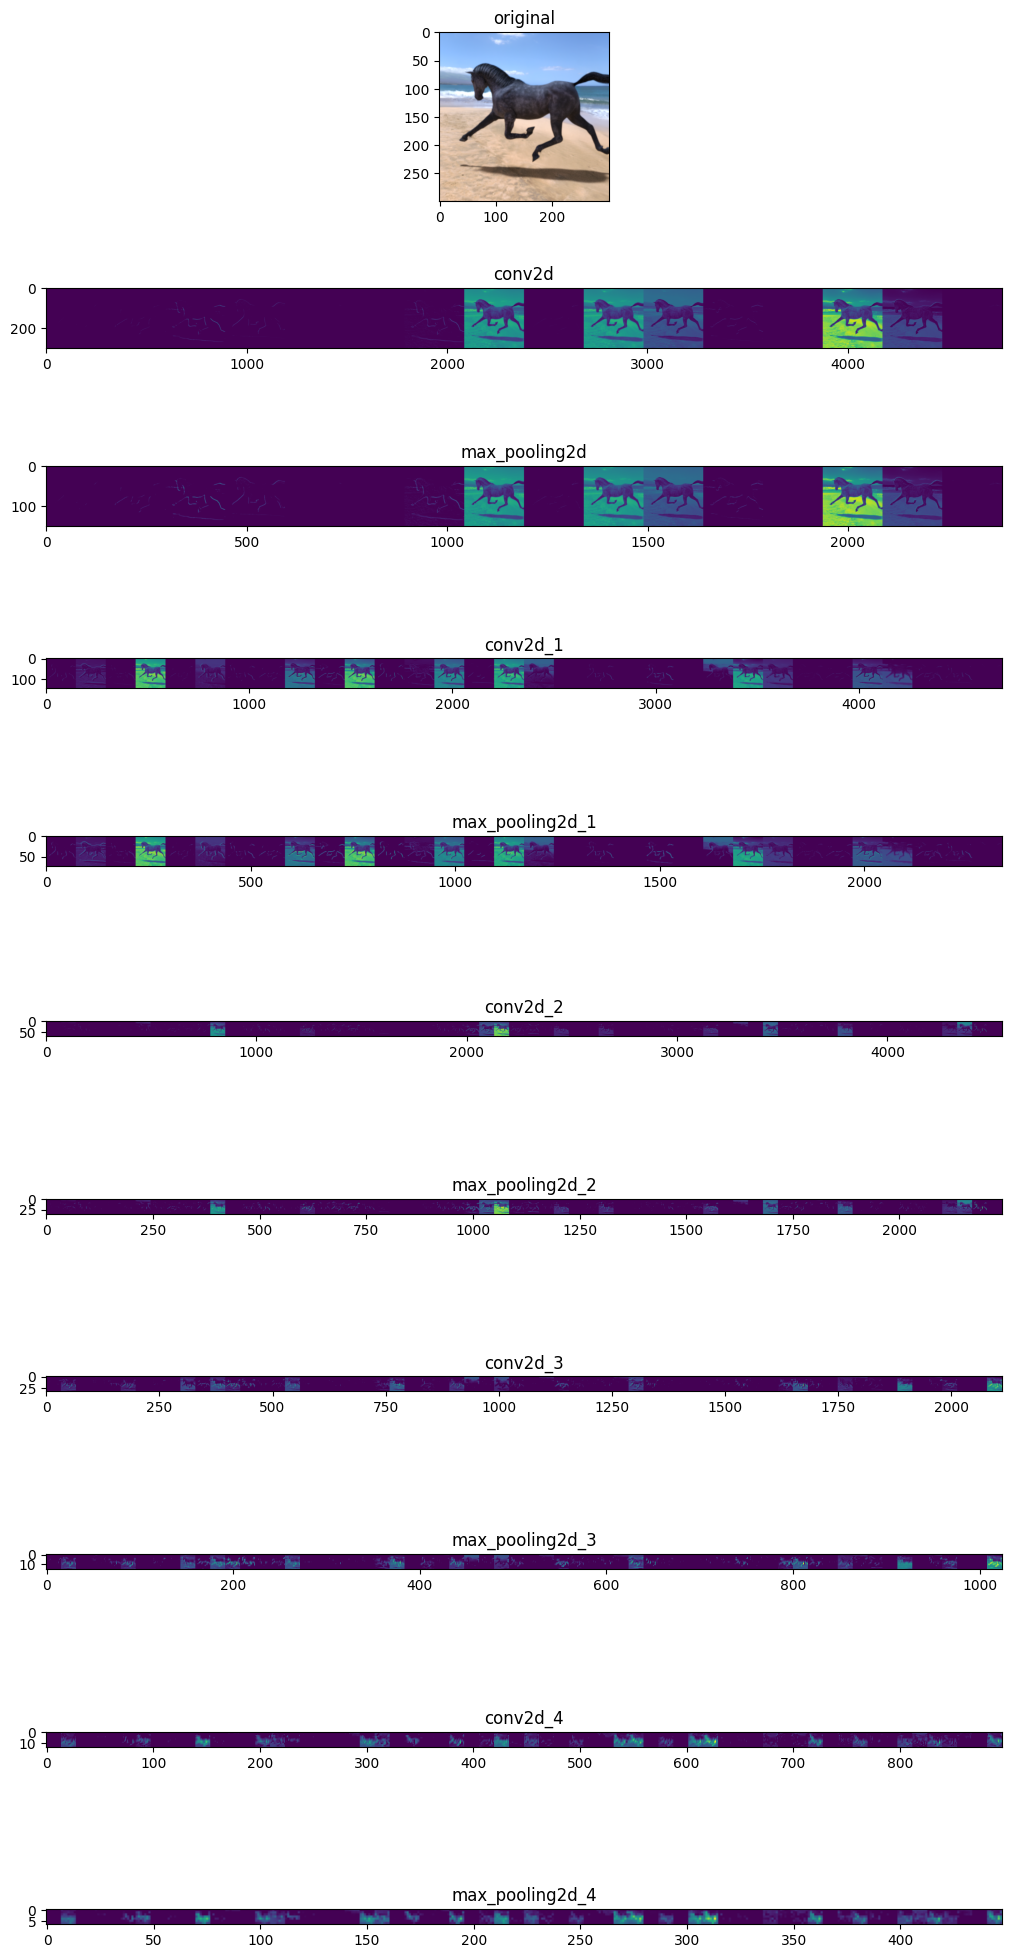

In [21]:
_, axs = plt.subplots(num_l + 1, figsize=(10, num_l * 2), layout='constrained')
x = utils.load_img('horse-or-human/horses/horse04-8.png', target_size=(300, 300))
axs[0].imshow(x)
axs[0].set_title('original')
axs[0].grid(False)
successive_feature_maps = features_model.predict(
    np.expand_dims(x, axis=0)
)
for i, layer_name, feature_map in zip(
    range(1, num_l + 1), layer_names, successive_feature_maps
):
    n_features = feature_map.shape[-1]
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * n_features))
    for j in range(n_features):
        display_grid[:, j*size : (j+1)*size] = feature_map[0, :, :, j]
    axs[i].imshow(display_grid)
    axs[i].set_title(layer_name)
    axs[i].grid(False)